In [1]:
! pip install pygments
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git # 설치 시 CLIPmodel 사용 가능

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-hsme21yd
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-hsme21yd
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done


In [2]:
import numpy as np
import torch

In [3]:
import clip  # CLIP에서 사용가능한 model

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [4]:
model, preprocess = clip.load("ViT-B/32")  #자신에게 맞는 model을 load 할수 있다
model.cuda().eval() # gpu에 올리기 위해 사용한다.

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [30]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# images in skimage to use and their textual descriptions
descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse", 
    "coffee": "a cup of coffee on a saucer"
}
original_images = []
images = []
texts = []
for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")
    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])


In [31]:
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda() # prompt engineering 과정이다.

In [32]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()
    image_features /= image_features.norm(dim=-1, keepdim=True) 
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T # cosine 유사도 구하는 과정이다, 여기서 T는 transpose를 말한다.(--> 내적을 위해)


Text(0.5, 1.0, 'Cosine similarity between text and image features')

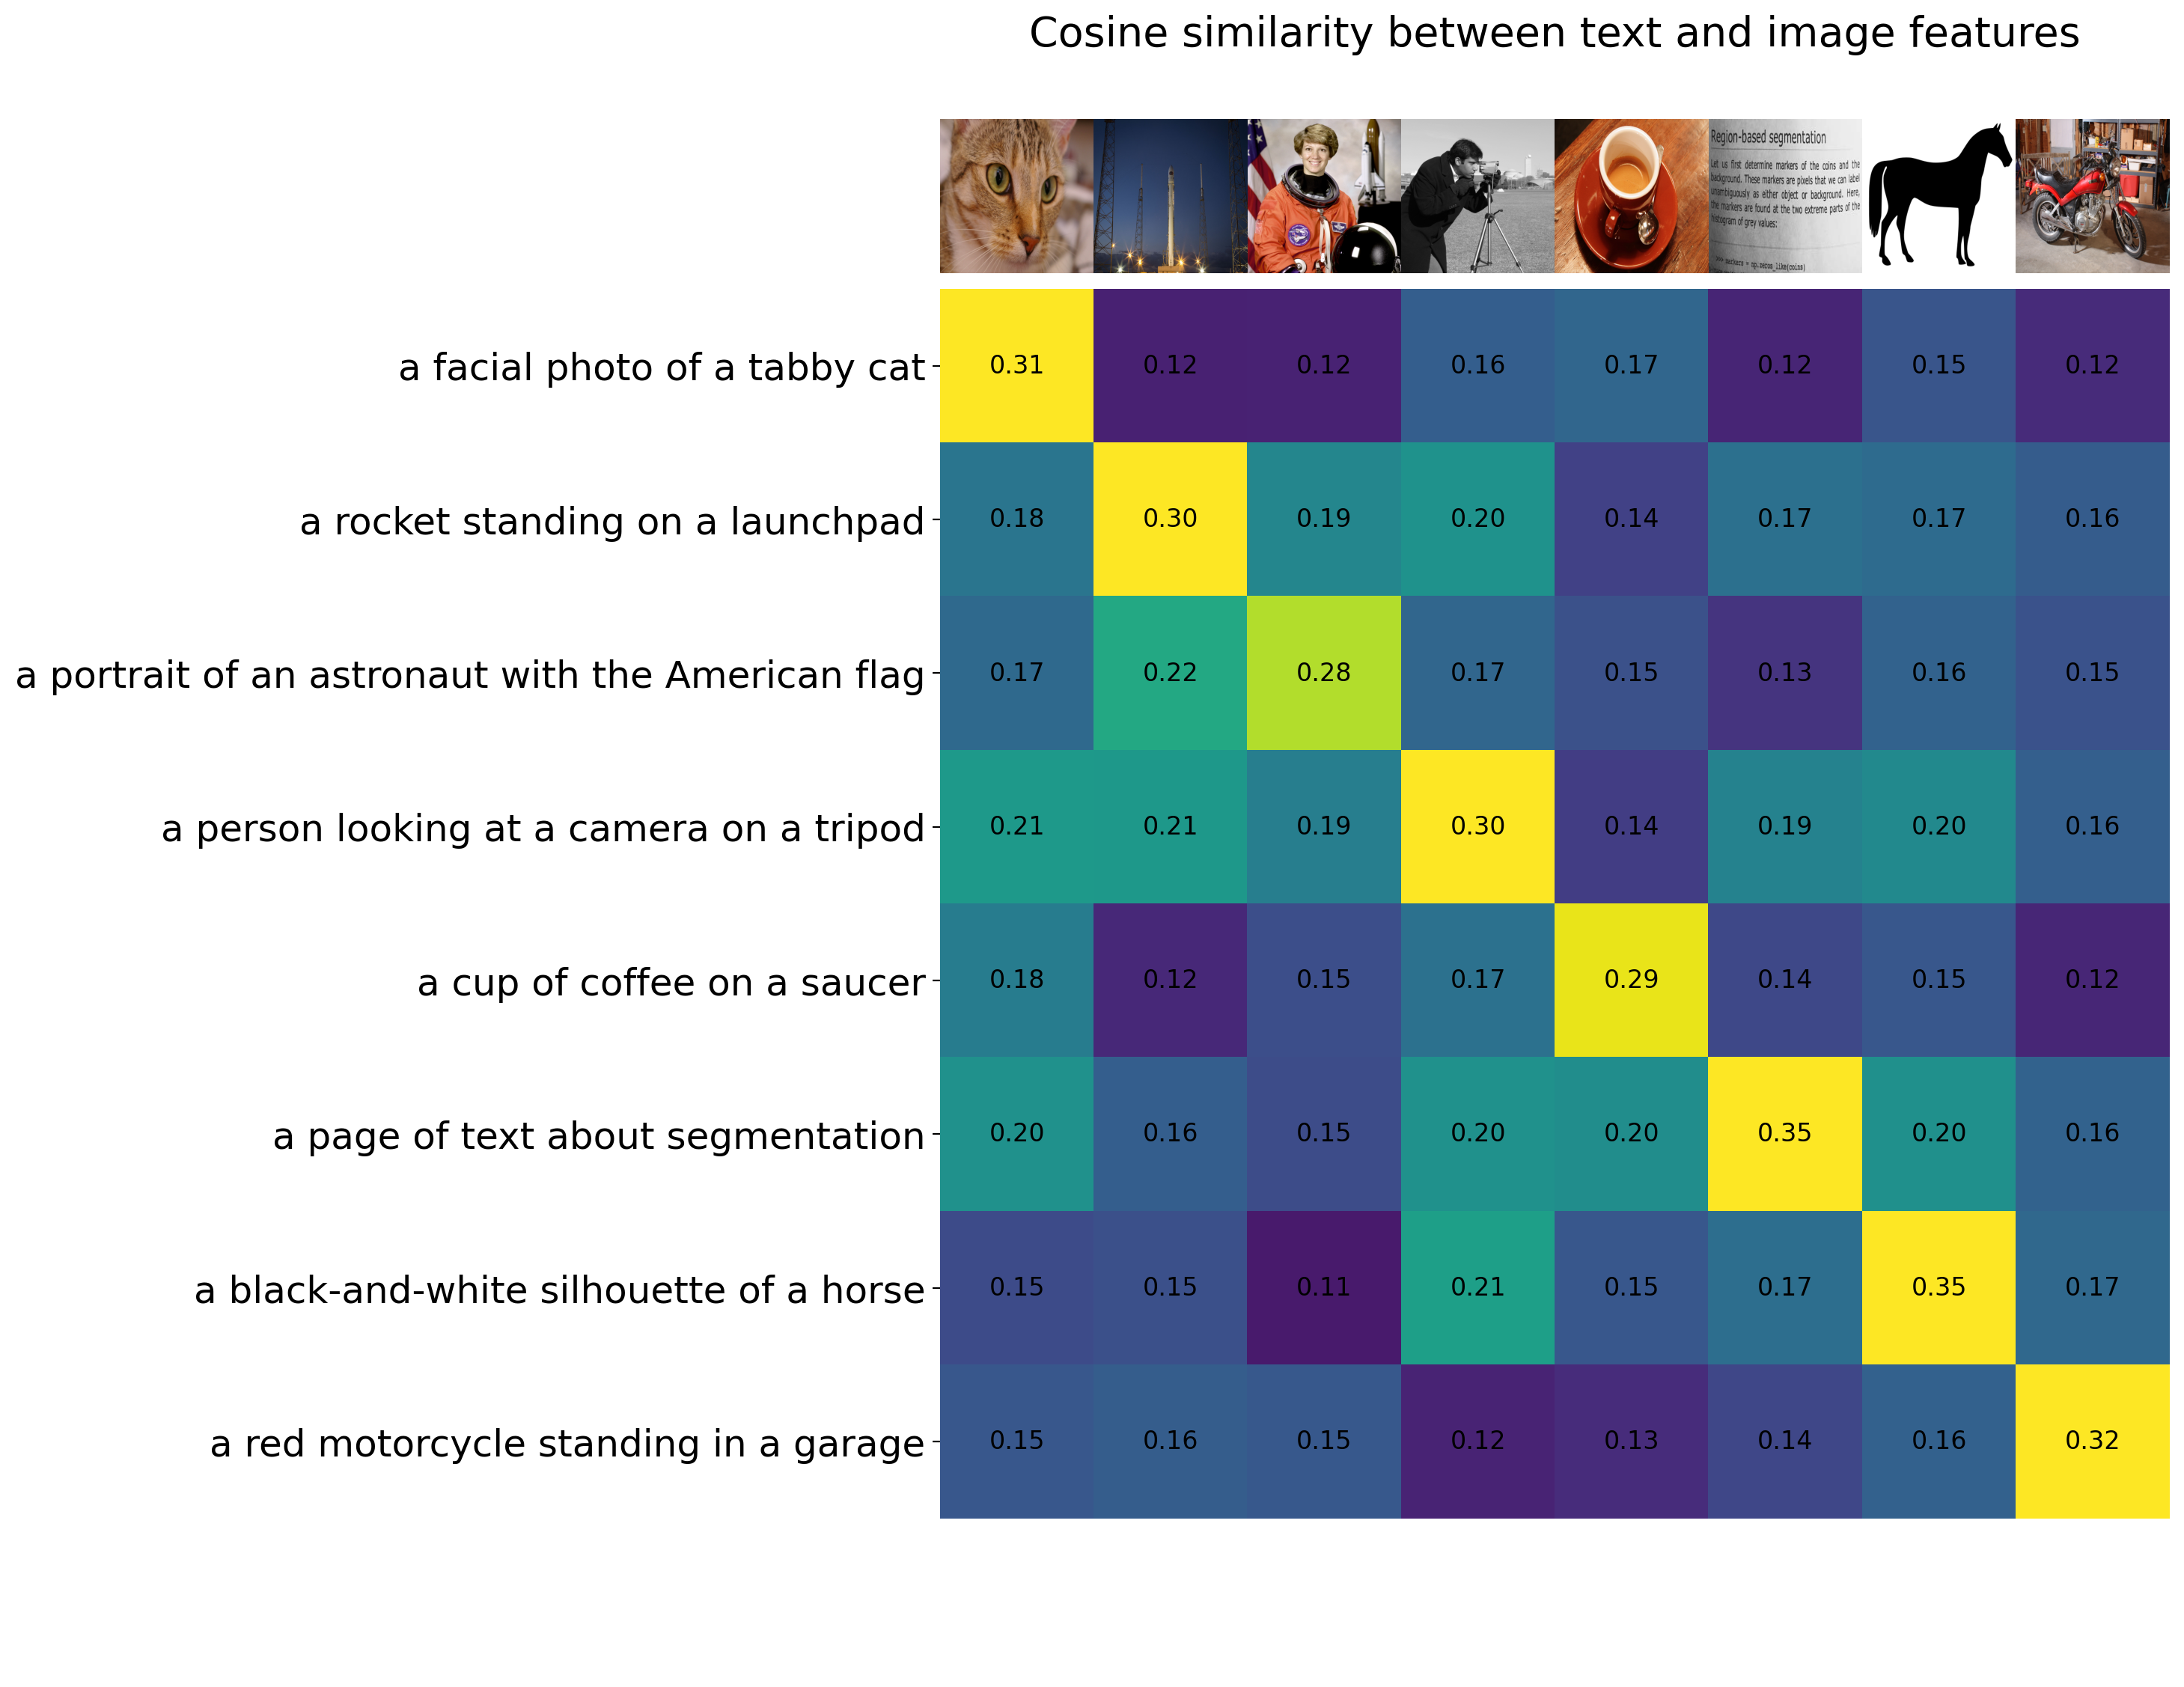

In [33]:
count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

In [34]:
from torchvision.datasets import CIFAR100
import os

cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True)
text_descriptions = [f"This is a photo of a {label}" for label in cifar100.classes]
text_tokens = clip.tokenize(text_descriptions).cuda()
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1) #새로운 text_features을 이용하여 새로운 label에 대해 분석한다.
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1) # 최대 5개 출력

Files already downloaded and verified


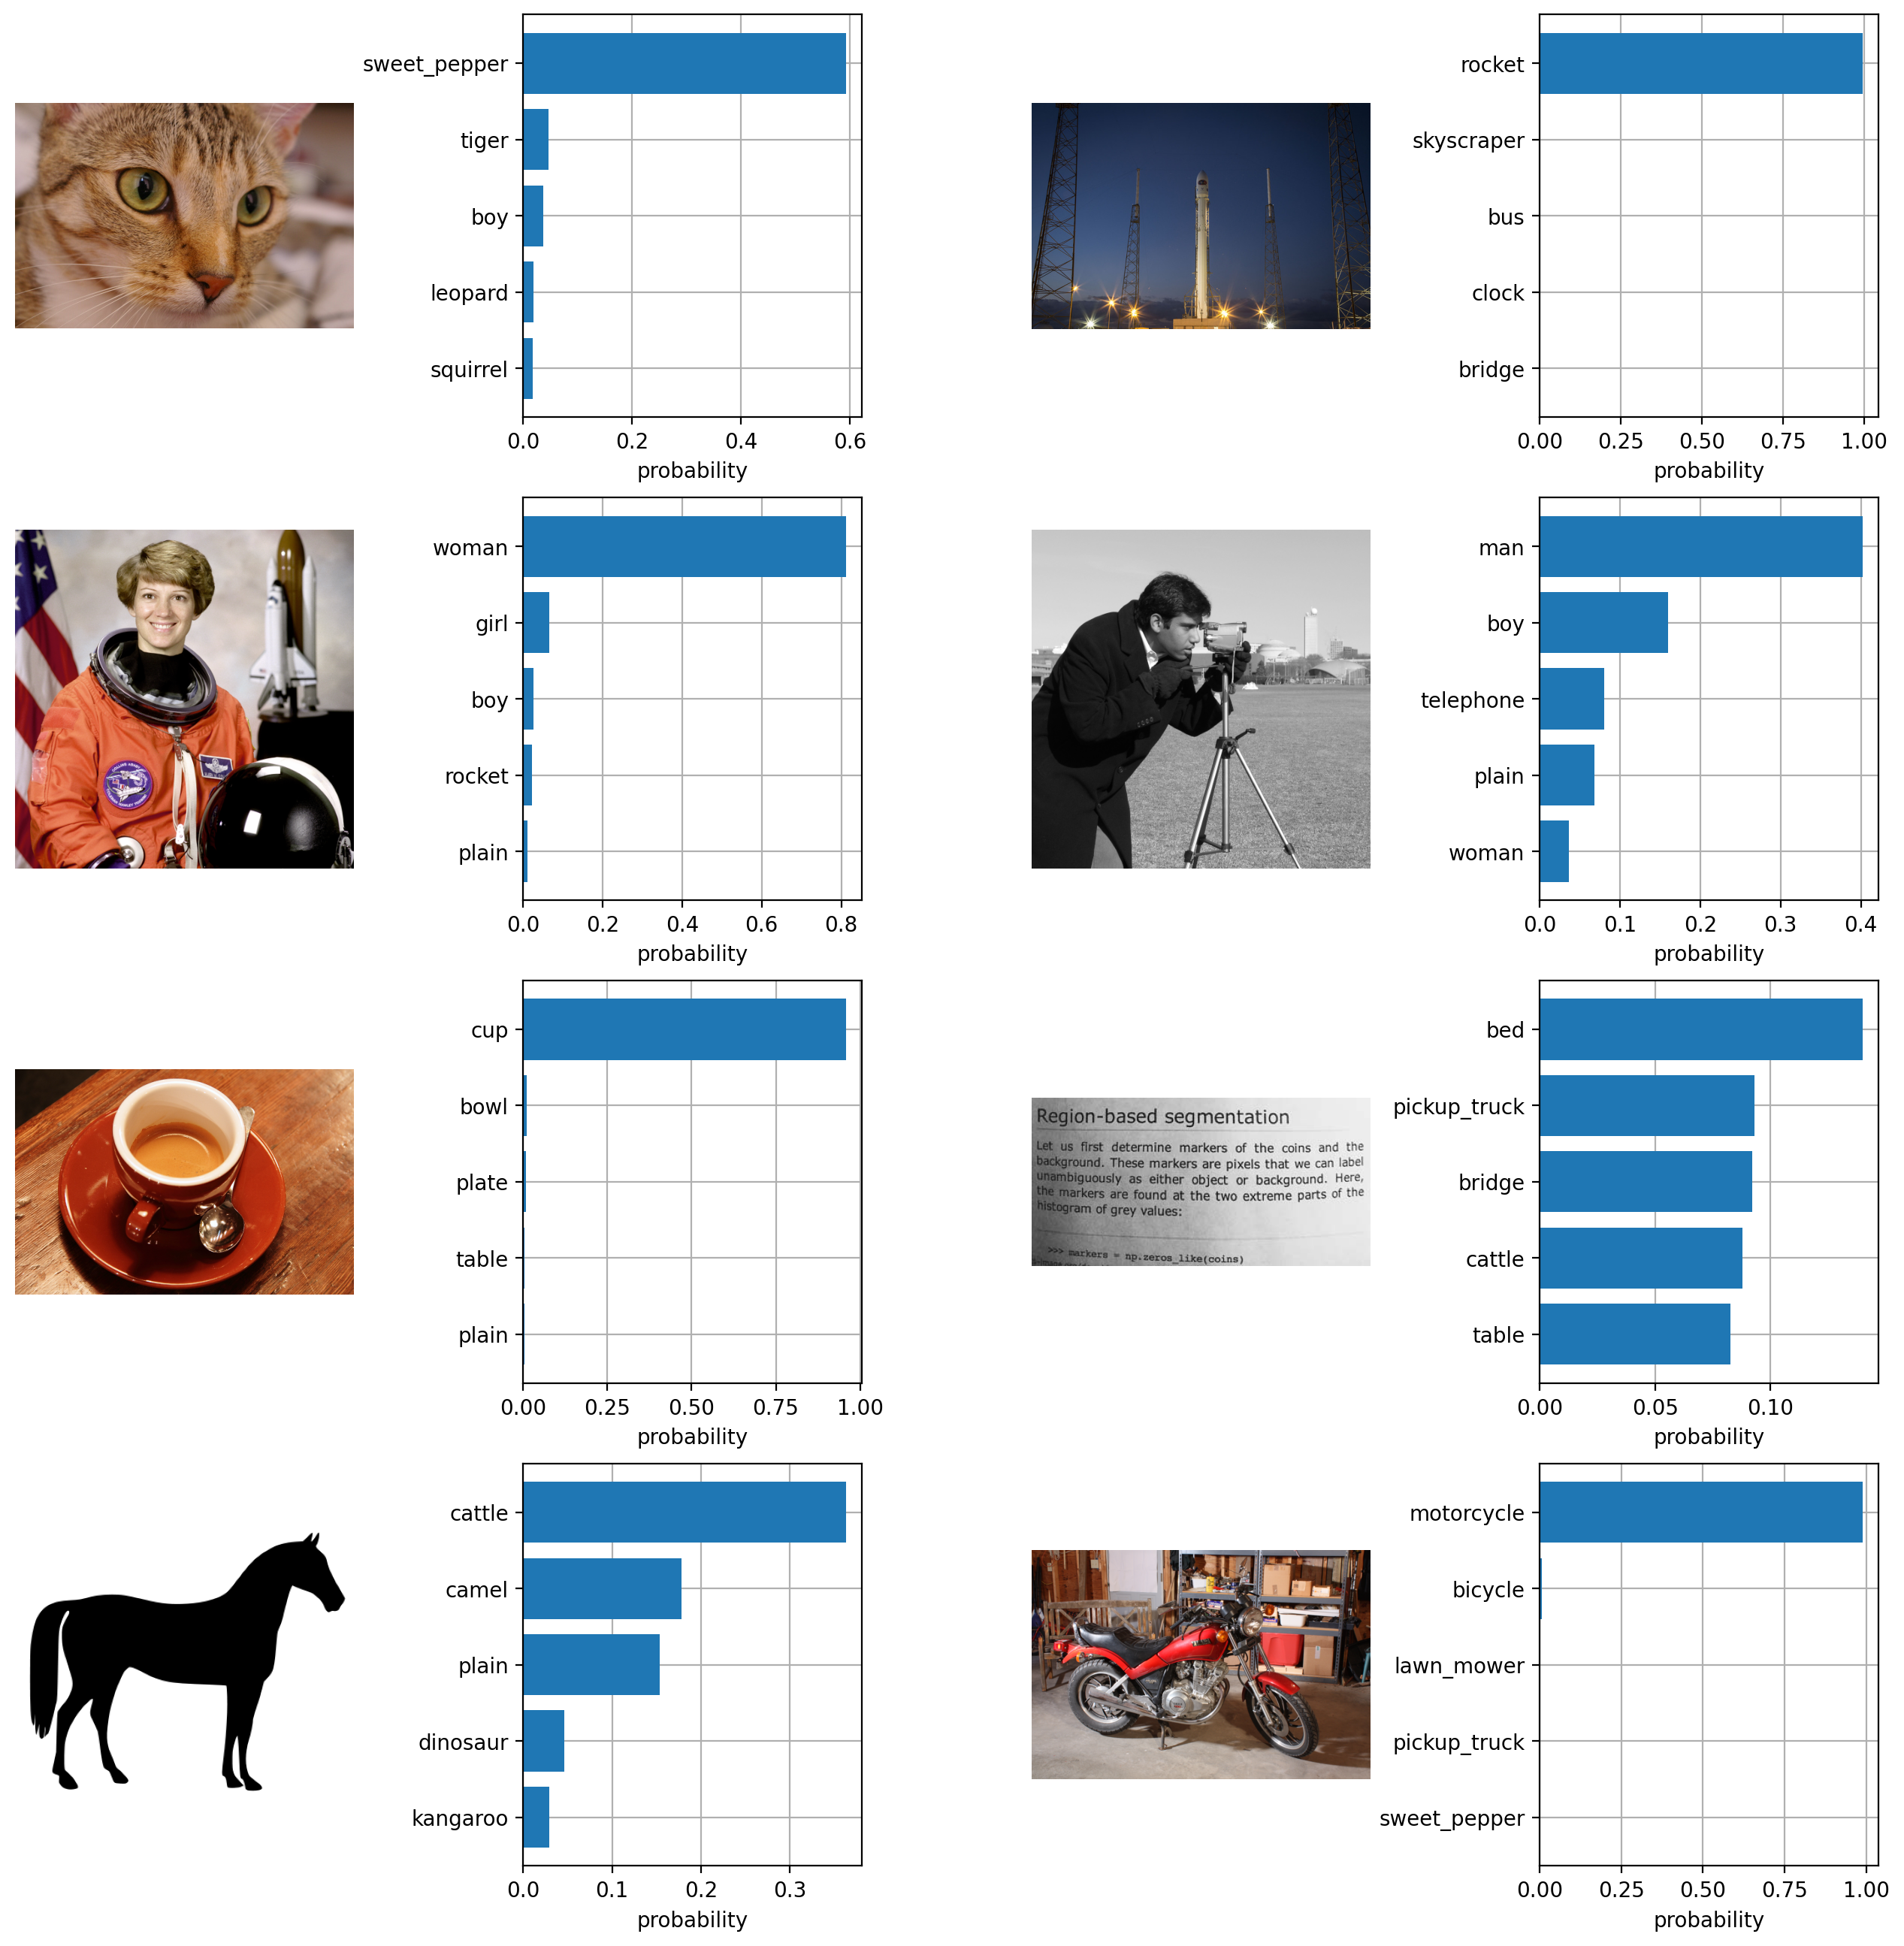

In [35]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [cifar100.classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()

In [5]:
import os
import clip
import torch

import numpy as np
from sklearn.linear_model import LogisticRegression
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR100
from tqdm import tqdm

# CIFAR100 데이터셋을 train과 test 버전으로 가져온다.
root = os.path.expanduser("~/.cache")
train = CIFAR100(root, download=True, train=True, transform=preprocess)
test = CIFAR100(root, download=True, train=False, transform=preprocess)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
test_loader = DataLoader(dataset=test,batch_size=100,shuffle=True)

In [7]:
cifar100_classes = ["apple", "aquarium_fish", "baby", "bear", "beaver", 
                    "bed", "bee", "beetle", "bicycle", "bottle", "bowl",
                      "boy", "bridge", "bus", "butterfly", "camel", "can",
                        "castle", "caterpillar", "cattle", "chair", "chimpanzee",
                          "clock", "cloud", "cockroach", "couch", "crab", "crocodile", "cup", "dinosaur", "dolphin", "elephant", "flatfish", "forest", "fox", "girl", "hamster", "house", "kangaroo", "keyboard", "lamp", "lawn_mower", "leopard", "lion", "lizard", "lobster", "man", "maple_tree", "motorcycle", "mountain", "mouse", "mushroom", "oak_tree", "orange", "orchid", "otter", "palm_tree", "pear", "pickup_truck", "pine_tree", "plain", "plate", "poppy", "porcupine", "possum", "rabbit", "raccoon", "ray", "road", "rocket", "rose", "sea", "seal", "shark", "shrew", "skunk", "skyscraper", "snail", "snake", "spider", "squirrel", "streetcar", "sunflower", "sweet_pepper", "table", "tank", "telephone", "television", "tiger", "tractor", "train", "trout", "tulip", "turtle", "wardrobe", "whale", "willow_tree", "wolf", "woman", "worm"]
# zeroshot을 위해 class 정보를 text 형태로 저장한다

In [8]:
text = ["This is "+ a for a in cifar100_classes] # CLIP논문에서 언급한 prompt engineering 과정이다.
texts = clip.tokenize(text).cuda() # 실제로는 token화를 거쳐서 입력으로 들어 감으로 CLIP에서 제공해주는 tokenize 모듈을 사용하는 과정이다.

In [9]:
def accuracy(output, target, topk=(1,)):
    pred = output.topk(max(topk), 1, True, True)[1].t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    return  [float(correct[:k].reshape(-1).float().sum(0, keepdim=True).cpu().numpy()) for k in topk] # zeroshot 성능을 확인하기위해 상위 5개와 상위 1개의 정확도를 측정하는 과정이다.

In [10]:
with torch.no_grad():
    top1, top5, n = 0., 0., 0.
    for i, (images, target) in enumerate(tqdm(test_loader)):
        images = images.cuda()
        target = target.cuda()
        
        # predict
        real_image_features = model.encode_image(images) # model의 image encoder ("ViT-B/32")
        real_image_features /= real_image_features.norm(dim=-1, keepdim=True)
        real_text_features = model.encode_text(texts) # model의 text enocoder (transformer)/ token화된 input을 받는다
        real_text_features /= real_text_features.norm(dim=-1, keepdim=True)

        logits = 100. * real_image_features @ real_text_features.t()  # cosine similarity를 구하는 과정이다. 이를 통해 최종 label을 확인 할수 있다.

        # measure accuracy
        acc1, acc5 = accuracy(logits, target, topk=(1, 5))
        top1 += acc1
        top5 += acc5
        n += images.size(0)

top1 = (top1 / n) * 100
top5 = (top5 / n) * 100
top1 = float(top1)
top5 = float(top5)


print(f"Top-1 accuracy: {top1:.2f}")
print(f"Top-5 accuracy: {top5:.2f}")

100%|██████████| 100/100 [00:21<00:00,  4.59it/s]

Top-1 accuracy: 44.47
Top-5 accuracy: 68.33


In [15]:
import torch
from torchvision.datasets import CIFAR100
from torchvision import transforms
from collections import defaultdict



def select_images_per_class(dataset, num_per_class):
    class_images = defaultdict(list)
    for image, label in dataset:
        if len(class_images[label]) < num_per_class: #num_per_class의 수 만큼 각 label에 image들이 구성된다.
            class_images[label].append((image, label))
        if len(class_images) == 100 and all(len(images) == num_per_class for images in class_images.values()):
            break
    selected_images = []
    selected_labels = []
    for label, images in class_images.items():
        for image, label in images:
            selected_images.append(image)
            selected_labels.append(label)
    return selected_images, selected_labels

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]


selected_images_1, selected_labels_1 = select_images_per_class(train, 1)
selected_images_3, selected_labels_3 = select_images_per_class(train, 3)
selected_images_5, selected_labels_5 = select_images_per_class(train, 5)
selected_images_7, selected_labels_7 = select_images_per_class(train, 7)

one_shot_datasets = CustomDataset(selected_images_1, selected_labels_1)
three_shot_datasets = CustomDataset(selected_images_3, selected_labels_3)
five_shot_datasets = CustomDataset(selected_images_5, selected_labels_5)
seven_shot_datasets = CustomDataset(selected_images_7, selected_labels_7)



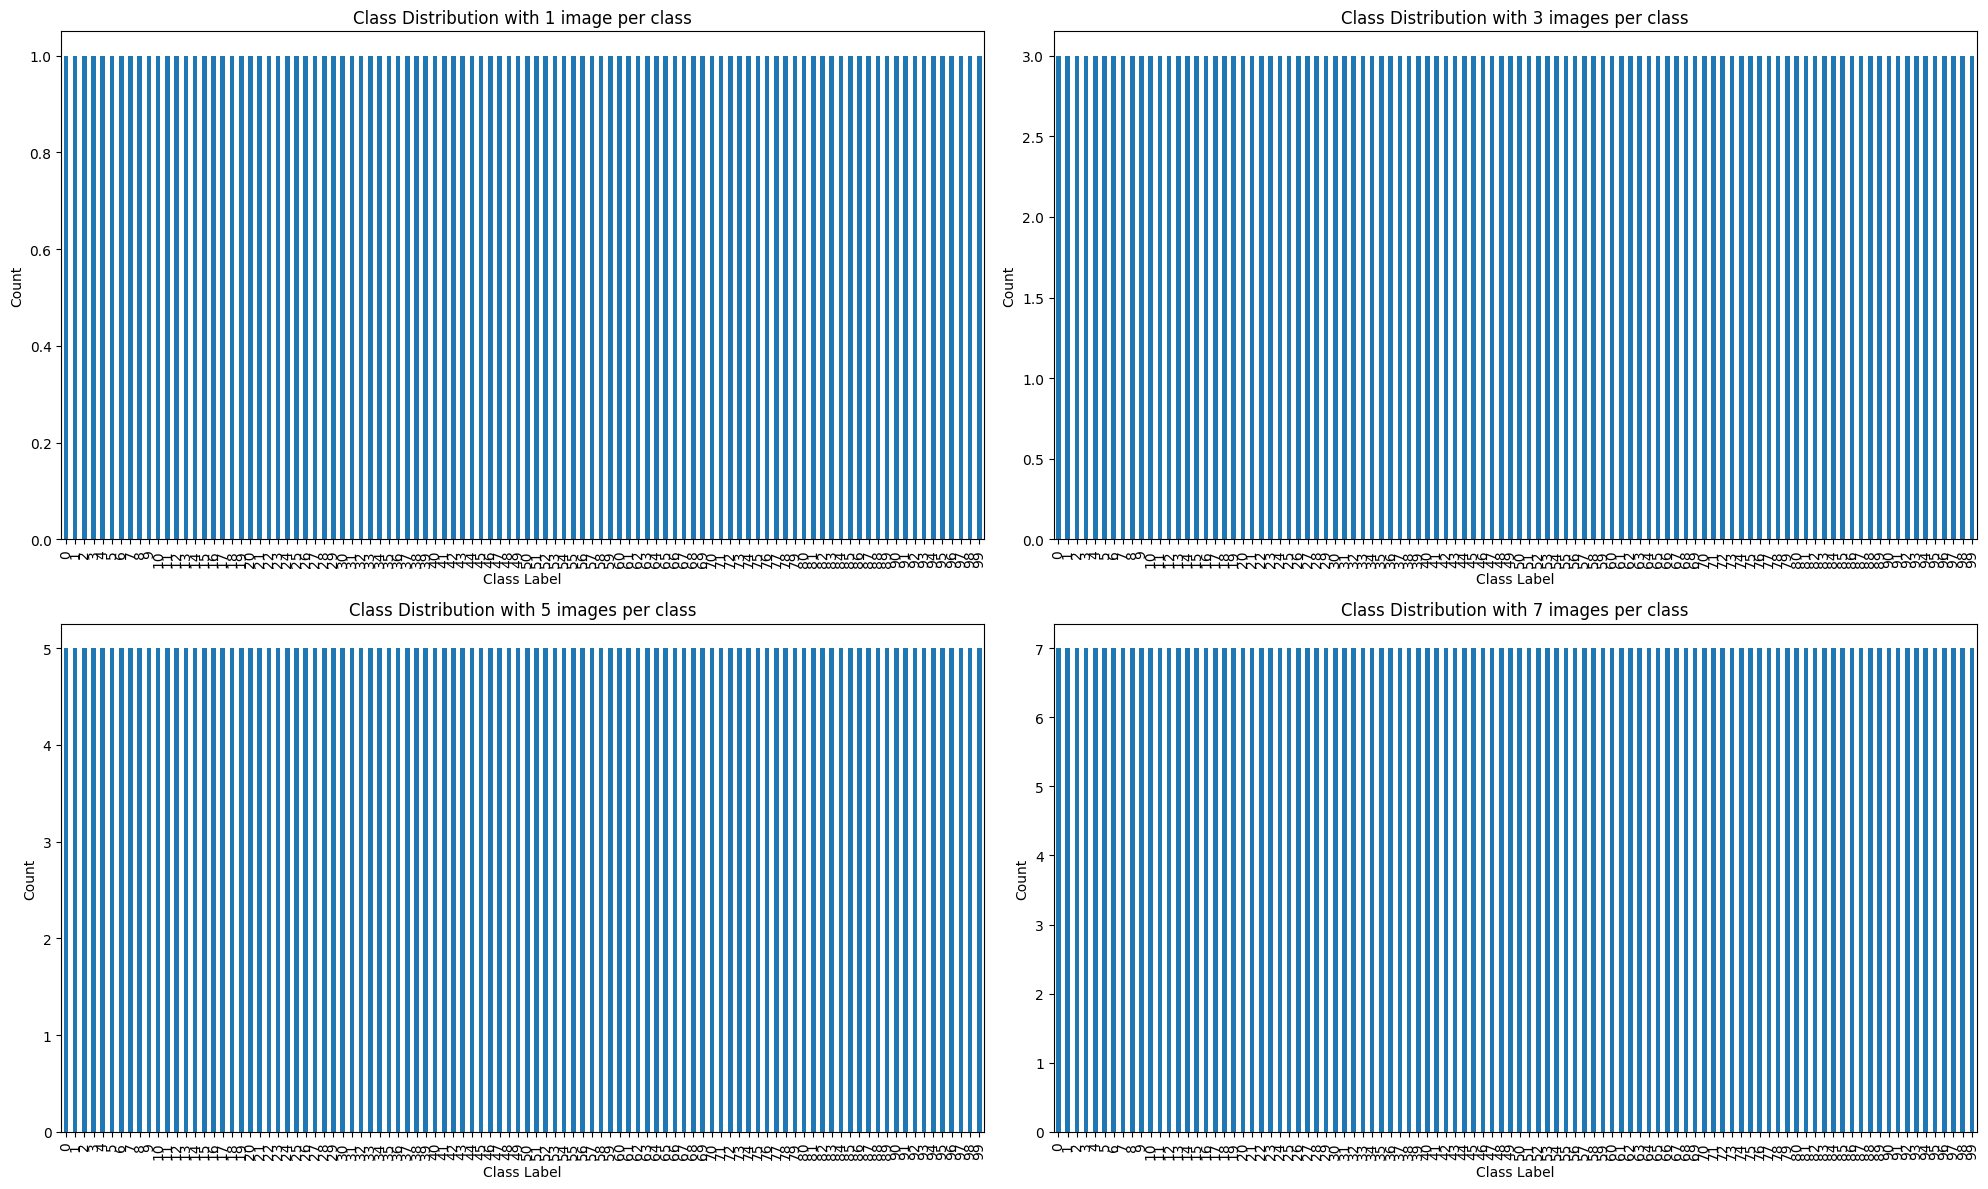

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
datasets = [(selected_labels_1, '1 image per class'), 
            (selected_labels_3, '3 images per class'), 
            (selected_labels_5, '5 images per class'), 
            (selected_labels_7, '7 images per class')]

for ax, (labels, title) in zip(axes.flatten(), datasets):
    label_counts = pd.Series(labels).value_counts().sort_index()
    label_counts.plot(kind='bar', ax=ax)
    ax.set_xlabel('Class Label')
    ax.set_ylabel('Count')
    ax.set_title(f'Class Distribution with {title}')

plt.tight_layout()
plt.show()  # 각 class 별로 몇개의 데이터가 들어가 있는지 확인 할수 있다.

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"
def get_features(dataset,number,shuffle):
    all_features = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(DataLoader(dataset, batch_size=number,shuffle = shuffle)):
            features = model.encode_image(images.to(device)) #one_shot 과정 진행시 CLIP의 encoder의 output부분의 feature 을 활용하여 진행된다.

            all_features.append(features)
            all_labels.append(labels)

    return torch.cat(all_features).cpu().numpy(), torch.cat(all_labels).cpu().numpy()
test_features, test_labels = get_features(test,100,True)
train_oneshot, label_oneshot = get_features(one_shot_datasets,1,False) # 전체 feature 정보를 다가져오기위해
train_threeshot, label_threeshot = get_features(three_shot_datasets,3,False)
train_fiveshot, label_fiveshot = get_features(five_shot_datasets,5,False)
train_sevenshot, label_sevenshot = get_features(seven_shot_datasets,7,False)

100%|██████████| 100/100 [00:00<00:00, 105.34it/s]


In [24]:
classifier_oneshot = LogisticRegression(random_state=0, C=0.316, max_iter=1000, verbose=1) 
classifier_oneshot.fit(train_oneshot, label_oneshot) # linear probe를 학습하는 코드이다.
predictions_oneshot = classifier_oneshot.predict(test_features)
accuracy_oneshot = np.mean((test_labels == predictions_oneshot).astype(float)) * 100.
print(f"Accuracy_oneshot = {accuracy_oneshot:.3f}") # 정확성 지표이다.

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        51300     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.60517D+02    |proj g|=  2.98455D+00


 This problem is unconstrained.



At iterate   50    f=  1.89218D+02    |proj g|=  4.83301D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
51300     98    104      1     0     0   8.050D-04   1.892D+02
  F =   189.21748897232709     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Accuracy_oneshot = 31.070


In [25]:
classifier_threeshot = LogisticRegression(random_state=0, C=0.316, max_iter=1000, verbose=1) 
classifier_threeshot.fit(train_threeshot, label_threeshot) # linear probe를 학습하는 코드이다.
predictions_threeshot = classifier_threeshot.predict(test_features)
accuracy_threeshot = np.mean((test_labels == predictions_threeshot).astype(float)) * 100.
print(f"Accuracy_threeshot = {accuracy_threeshot:.3f}") # 정확성 지표이다.

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        51300     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.38155D+03    |proj g|=  6.76302D+00


 This problem is unconstrained.



At iterate   50    f=  4.64167D+02    |proj g|=  6.42949D-01

At iterate  100    f=  4.63926D+02    |proj g|=  5.18985D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
51300    132    142      1     0     0   1.026D-03   4.639D+02
  F =   463.92517566248762     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Accuracy_threeshot = 48.470


In [26]:
classifier_fiveshot = LogisticRegression(random_state=0, C=0.316, max_iter=1000, verbose=1) 
classifier_fiveshot.fit(train_fiveshot, label_fiveshot) # linear probe를 학습하는 코드이다.
predictions_fiveshot = classifier_fiveshot.predict(test_features)
accuracy_fiveshot = np.mean((test_labels == predictions_fiveshot).astype(float)) * 100.
print(f"Accuracy_fiveshot = {accuracy_fiveshot:.3f}") # 정확성 지표이다.

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        51300     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.30259D+03    |proj g|=  1.07574D+01


 This problem is unconstrained.



At iterate   50    f=  7.03360D+02    |proj g|=  1.49617D+00

At iterate  100    f=  7.00191D+02    |proj g|=  3.05250D-02

At iterate  150    f=  7.00189D+02    |proj g|=  2.99745D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
51300    174    186      1     0     0   3.009D-03   7.002D+02
  F =   700.18783968503976     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Accuracy_fiveshot = 56.900


In [27]:
classifier_sevenshot = LogisticRegression(random_state=0, C=0.316, max_iter=1000, verbose=1) 
classifier_sevenshot.fit(train_sevenshot, label_sevenshot) # linear probe를 학습하는 코드이다.
predictions_sevenshot = classifier_sevenshot.predict(test_features)
accuracy_sevenshot = np.mean((test_labels == predictions_sevenshot).astype(float)) * 100.
print(f"Accuracy_sevenshot = {accuracy_sevenshot:.3f}") # 정확성 지표이다.

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        51300     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.22362D+03    |proj g|=  1.28228D+01


 This problem is unconstrained.



At iterate   50    f=  8.98834D+02    |proj g|=  1.06117D+00

At iterate  100    f=  8.94807D+02    |proj g|=  3.27562D-01

At iterate  150    f=  8.94801D+02    |proj g|=  6.67533D-02

At iterate  200    f=  8.94800D+02    |proj g|=  8.78467D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
51300    208    221      1     0     0   9.432D-03   8.948D+02
  F =   894.79943211213208     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Accuracy_sevenshot = 60.350


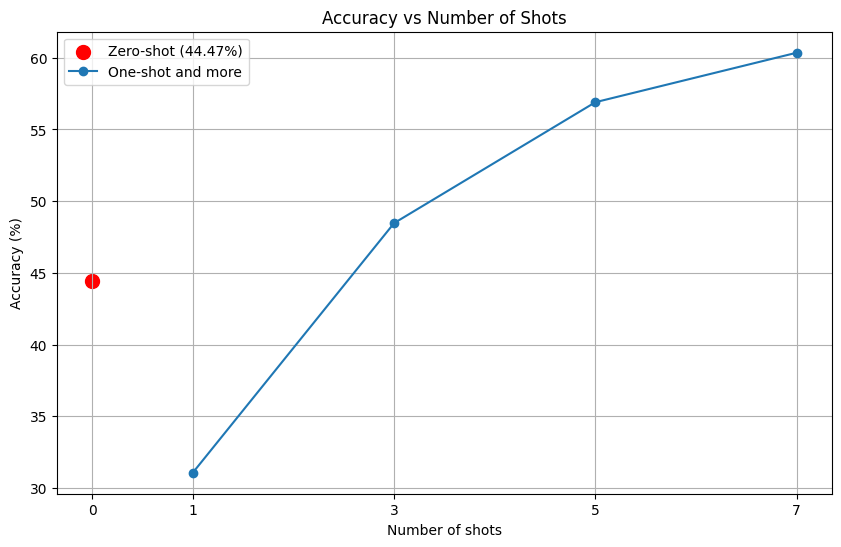

In [29]:
import matplotlib.pyplot as plt

shots = [0, 1, 3, 5, 7]
accuracies = [44.47, 31.070, 48.470, 56.900, 60.350]

plt.figure(figsize=(10, 6))

# 큰 점을 위해 scatter 사용
plt.scatter([shots[0]], [accuracies[0]], color='red', s=100, label='Zero-shot (44.47%)')  

# 나머지 점을 선으로 연결하여 표현
plt.plot(shots[1:], accuracies[1:], marker='o', label='One-shot and more')

# x축의 틱 설정
plt.xticks(shots)

plt.xlabel('Number of shots')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Number of Shots')
plt.grid(True)
plt.legend()
plt.show() # 이 결과를 통해  zero shot일때의 확률이 one_shot가 비교시 좋다가 shot을 추가 할수록 zeroshot의 성능을 넘어가는것을 확인 할 수 있다. --> 실험 결과 증명
